# Mathematics for Quantum Information and Intro to Qiskit Part II

In this notebook we continue to explore the mathematics of quantum information and get hands-on practice in Qiskit. This time we get a look at multiple qubits, multi-qubit gates, entanglement, and more!

### Logisitics

* The notebook is hosted on [GitHub](https://github.com/rmlarose/QuIC-Seminar). All other QuIC Seminar notebooks will be.
* It can be viewed online with [Notebook Viewer]().
* It can be run online with [Binder](). 
* The [QuIC Seminar website](https://ryanlarose.com/quic-seminar) has links to all QuIC Seminar materials.

In [8]:
"""Imports and notebook setup."""
import warnings

import numpy as np

import qiskit
import qiskit.tools.qi.qi as qi
from qiskit import (BasicAer, execute, QuantumCircuit)

%matplotlib inline

In [9]:
_req_ver = "0.9.0"
if _req_ver not in qiskit.__version__:
    warnings.warn(
        "This notebook is written for Qiskit version 0.9.0." + 
        "Your code may not execute properly with other versions."
    )

## Multiple qubits and entanglement

So far, we've only investigated single qubits and single qubit gates. However, the real power of a quantum computer comes from allowing our qubits to interact with each other and become __entangled__. Entanglement is the idea that after two quantum systems interact with each other, we may no longer describe them as two independent systems: they become two parts of a larger __multipartite__ quantum system. A multipartite quantum system is quite literally more than the sum of its parts: it takes more information for us to characterize it than it would to characterize its individual constituents. In your undergraduate (and even graduate!) quantum mechanics course, you were probably told entanglement exists, and then promptly swept it under the rug. For us, entanglement isn't a nuisance we can ignore: entanglement is a *resource* for a quantum computer. 

Let's get some notational jargon out of the way. Assume we have two qubits

$$|\psi\rangle = \psi_0|0\rangle + \psi_1|1\rangle \\ |\varphi\rangle = \varphi_0|0\rangle + \varphi_1|1\rangle$$

We may characterize combined quantum system with the __tensor product__ of these two states is defined as


$$|\psi\rangle \otimes |\varphi\rangle = \psi_0\varphi_0(|0\rangle \otimes |0\rangle) + \psi_1\varphi_0(|1\rangle \otimes |0\rangle) + \psi_0\varphi_1(|0\rangle \otimes |1\rangle) + \psi_1\varphi_1(|1\rangle \otimes |1\rangle) \\ = \psi_0\varphi_0|00\rangle + \psi_1\varphi_0|10\rangle + \psi_0\varphi_1|01\rangle + \psi_1\varphi_1|11\rangle = \begin{pmatrix} \psi_0\varphi_0 \\ \psi_1\varphi_0 \\ \psi_0\varphi_1 \\ \psi_1\varphi_1 \end{pmatrix}$$

The second line showcases a common notational abbreviation, where we drop the tensor product and combine all the single qubit kets into one multiqubit ket. Our new bipartite quantum system has dimensionality $2 \times 2 = 4$: it's now a vector in $\mathbb{C}^4$ instead of two vectors in $\mathbb{C}^2$. In general, if we had a system with dimensionality $n$ and another with dimensionality $m$, the combined system would have dimensionality $m\times n$.

Likewise, any operator that acts on our bipartite quantum sistem $|\psi\varphi\rangle$ must now be a $4\times 4$ matrix. If we have two single qubit operators, $\mathbf{A}$ that acts on $|\psi\rangle$ and $\mathbf{B}$ that acts on $|\varphi\rangle$, we can construct a two an operator $\mathbf{A}\otimes\mathbf{B}$ that acts on $|\psi\varphi\rangle$ in the following way:

$$\mathbf{A}\otimes\mathbf{B} = \begin{pmatrix} a_{11}\mathbf{B} & a_{12}\mathbf{B} \\ a_{21}\mathbf{B} & a_{22}\mathbf{B} \end{pmatrix} = \begin{pmatrix} a_{11}b_{11} & a_{12}b_{11} & a_{11}b_{12} & a_{12}b_{12} \\ a_{21}b_{11} & a_{22}b_{11} & a_{21}b_{12} & a_{21}b_{12} \\ a_{11}b_{21} & a_{12}b_{21} & a_{11}b_{22} & a_{12}b_{22} \\ a_{21}b_{21} & a_{22}b_{21} & a_{21}b_{22} & a_{21}b_{22}\end{pmatrix} $$

Likewise, this extends to higher dimensional quantum systems in in a similar fashion to the tensor product. To get a feel for how this works, and to see how python handles these operations, play around with the code below to create some multipartite state vectors/operators. Note that the order in which you take the tensor product matters! 

$\color{red}{\text{Some exercises you might be interested in doing:}}$

- What happens when I tensor product 3 qubits together? What is the dimension of the total Hilbert space now? 4 qubits? $n$ qubits? Why can't we efficiently simulate a quantum computer on a classical computer?

- How would I write an effective one qubit operator that acts on the combined Hilbert space. For example, how would I apply a Pauli-X gate to the first qubit and do nothing to the second qubit?


## An important two qubit gate: the CNOT

An example of a two qubit operator that we'll be using all the time is the CNOT, or controlled-NOT, gate. This operation can be summed up as "if the first qubit is in $|1\rangle$, flip the second qubit, otherwise do nothing. A picture of what a CNOT gate looks like, as well as what it does in the four possible state configurations, is given below. The __control__ qubit is the one with the dot, and the __target__ qubit is the one with the cross on it. You may also see the CNOT gate be called the CX or controlled-X gate. Why is that?

<img src="cnot_vis.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook. Reproduced from https://arxiv.org/pdf/0906.0645.pdf" align="middle">

#### Potentially important side note

Now is as good a time as any to mention a weird quirk of qiskit: when defining a quantum circuit with qubits $|a\rangle, |b\rangle, |c\rangle...$ in the $0^{th}, 1^{st}, 2^{nd}...$ positions, qiskit writes down a multi qubit state as $|...cba\rangle$ instead of $|abc...\rangle$, which is the convention used in most text books. Because of that, in qiskit, the matrix for a CNOT gate where the top qubit is the control and the bottom is the target is written in the $\begin{pmatrix} |00\rangle& |01\rangle &  |10\rangle & |11\rangle \end{pmatrix}$ basis looks like

$$\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \end{pmatrix}$$

as opposed to the more common form which looks like 

$$\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$$

#### End potentially important side note

An important feature of the CNOT gate is that it can't be built out of the tensor product of single qubit gates. This means that, using the CNOT gate, we can entangle two qubits! Below is a circuit that uses a Hadamard and a CNOT gate to prepare the famous "Bell state" of two qubits $|\psi\rangle = 1/\sqrt{2}(|00\rangle + |11\rangle)$. Run through the math and make sure you understand how this circuit makes a Bell state!

In [10]:
"""Create the CNOT gate with tensor products of Pauli operators."""
# Projectors |0><0| and |1><1|
pi0 = np.array([[1, 0], [0, 0]])
pi1 = np.array([[0, 0], [0, 1]])

# Pauli operators
imat = np.array([[1, 0], [0, 1]])
xmat = np.array([[0, 1],[1, 0]])

# Create CNOT_01
cnot01 = np.kron(pi0, imat) + np.kron(pi1, xmat)
print(cnot01)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]


In [11]:
"""Use the CNOT gate in Qiskit to create a Bell state."""
# Define three different circuits. The reason will be clear shortly.
bell = QuantumCircuit(2, 2)
meas1 = QuantumCircuit(2, 2)
meas2 = QuantumCircuit(2, 2)

# Add the gates to the circuits
bell.h(0)
bell.cx(0, 1) 
meas1.measure([0], [0])
meas2.measure([1], [1])

# Add the circuits
circ = bell + meas1 + meas2

# Display the circuit
print(circ.draw())

# Execute the circuit
backend = BasicAer.get_backend('qasm_simulator') # the device to run on
result = execute(circ, backend, shots=1000).result()
counts  = result.get_counts(circ)
print("Counts:")
print(counts)

        ┌───┐     ┌─┐   
q_0: |0>┤ H ├──■──┤M├───
        └───┘┌─┴─┐└╥┘┌─┐
q_1: |0>─────┤ X ├─╫─┤M├
             └───┘ ║ └╥┘
 c_0: 0 ═══════════╩══╬═
                      ║ 
 c_1: 0 ══════════════╩═
                        
Counts:
{'11': 504, '00': 496}


## The density matrix

A valid question to ask is "what is the single particle state vector of the first qubit in a bell state?" This seemingly innocuous has an incredibly profound answer: because the two qubits are entangled, *no single particle state vectir can entirely characterize the state of one qubit!* The entangled two qubit system is more than the sum of its parts.

To see why this is the case, we'll have to define a new way of characterizing quantum systems: the __density matrix__, which is the outer product of the state vector with itself $$\rho = |\psi\rangle\langle\psi|$$

The density matrix has several important properties (which you should verify!):

- It is Hermitian: $\rho^\dagger = \rho$
- It has unit trace: $\text{Tr}(\rho) = 1$
- The expectation value of some operator $\langle\mathbf{A}\rangle = \langle\psi|\mathbf{A}|\psi\rangle$ can be written as $\text{Tr}(\mathbf{A}\rho)$

As an example, let's use python to write down the density matrix of a Bell state in the $\begin{pmatrix} |00\rangle& |01\rangle &  |10\rangle & |11\rangle \end{pmatrix}$ basis. Since we already know how to take outer products, this is super easy.



In [12]:
"""Function from last time."""
def norm_state(arr): 
    '''
    Function that takes in an array of numbers and outputs a normalized array
    An array in python is writted down as [a,b,c,...] where a, b, and c are numbers
    May take in any length array, but for qubits we should use len(arr) = 2
    '''
    mag = np.sqrt(np.sum(np.array([abs(i)**2 for i in arr])))
    return np.array(arr) / mag

In [13]:
"""Density matrix of the Bell state."""
bell_sv = norm_state([1,0,0,1])
bell_dens_mat =  qi.outer(bell_sv, bell_sv)
print(bell_dens_mat)

[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


We can also visualize the Bell state by running the first half of our bell state creator circuit on the ```statevector_simulator``` backend. 

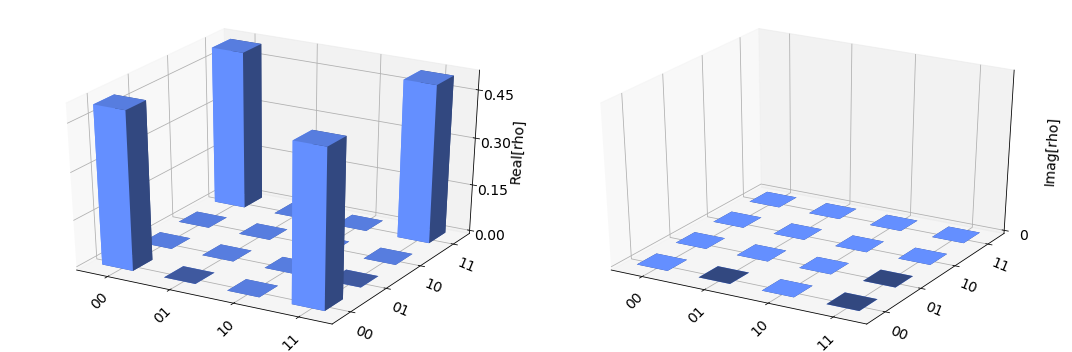

In [14]:
"""Visualization of the Bell state."""
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(bell, backend).result()
psi  = result.get_statevector(bell)

qiskit.visualization.plot_state_city(psi)

Right now, this probably seems like a needless complication. The key is that the density matrix formalism allows us to work with *part* of an entangled system: we can characterize a system with only partial knowledge of the full state.

To see how we do this, we need to define an operation called the __partial trace__. The partial trace is something like the tensor product in reverse: we start with the density matrix of a multipartite quantum system, "trace over" the degrees of freedom we don't care about, and end up with a lower dimensional density matrix for the subsystem we do care about. 

Let's make this concrete with a two qubit case. I have my first qubit $|\psi\rangle$ which lives in the Hilbert space $\mathcal{H}_A$ and my second qubit $|\varphi\rangle$ that lives in the Hilbert space $\mathcal{H}_B$. The combined state vector $|\psi\varphi\rangle = |\psi\rangle\otimes|\varphi\rangle$ lives in the composite Hilbert space $\mathcal{H}_A\otimes\mathcal{H}_B$. The density matrix for our combined system is $$\rho_{AB} = |\psi\varphi\rangle\langle\psi\varphi| = \rho_{11}|00\rangle\langle00| + \rho_{12}|00\rangle\langle01| + \rho_{13}|00\rangle\langle10| + ... + \rho_{44}|11\rangle\langle11| = 
\begin{pmatrix} \rho_{11} & \rho_{12} & \rho_{13} & \rho_{14} \\ \rho_{21} & \rho_{22} & \rho_{23} & \rho_{24}\\ \rho_{31} & \rho_{32} & \rho_{33} & \rho_{34} \\ \rho_{41} & \rho_{42} & \rho_{43} & \rho_{44} \end{pmatrix}$$

Now, to get a density matrix that describes the state of the first qubit (which lives in $\mathcal{H}_A$) I want to take a trace of the matrix only along the degrees of freedom in $\mathcal{H}_B$: $\rho_A = \text{Tr}_B(\rho_{AB})$. The standard procedure here is to block the density matrix up into submatrices (in the reverse of what we did when taking the tensor product) and then to trace over those submatrices. For the two qubit case, tracing over $\mathcal{H}_B$ looks like

$$ \rho_A =  \text{Tr}_B(\rho_{AB}) = \begin{pmatrix} \text{Tr}\begin{pmatrix} \rho_{11} & \rho_{12} \\ \rho_{21} & \rho_{22} \end{pmatrix} & \text{Tr}\begin{pmatrix} \rho_{13} & \rho_{14} \\ \rho_{23} & \rho_{24} \end{pmatrix} \\ \text{Tr}\begin{pmatrix} \rho_{31} & \rho_{32} \\ \rho_{41} & \rho_{42} \end{pmatrix} & \text{Tr}\begin{pmatrix} \rho_{33} & \rho_{34} \\ \rho_{43} & \rho_{44} \end{pmatrix} \end{pmatrix} $$

To make sure you understand what's going on, $\color{red}{\text{try and calculate } \rho_B = \text{Tr}_A(\rho_{AB})\text{. What do I need to do differently?}}$ If you want a more rigorous definition of the partial trace, check out [these](http://www.thphy.uni-duesseldorf.de/~ls3/teaching/1515-QOQI/Additional/partial_trace.pdf) notes that I found.

Taking the partial trace of the Bell state density matrix you found above is pretty easy! Qiskit has the ability to calculate partial traces (code below), but you probably didn't need it to find density matrix $\rho_A$ for the first qubit in the Bell state.

In [15]:
"""Taking the partial trace of the Bell state.

Explanation:

qi.partial_trace takes in three arguments:
    The first argument is a valid density matrix.
    The second argument is a list of the subsystems we want to trace over.
    The third argument is a list of the dimensions of all the subsystems.
        for the bell state, we have two subsystems with d = 2, so the second argument is [2,2]
        and we want to keep the 0th subsystem and trace over the 1st subsystem
        so our second argument is [1].
"""
qi.partial_trace(bell_dens_mat, [1],[2,2])

array([[0.5, 0. ],
       [0. , 0.5]])

You should have found that the density matrix for the first qubit is half the identity matrix, $\rho_A = 1/2 \mathbf{I}$. $\color{red}{\text{Here's an exercise for you: what state }|\psi\rangle\text{ gives me }|\psi\rangle\langle\psi| = 1/2\mathbf{I}?}$ 

In [16]:
"""Try and find a state vector that reproduces the above density matrix!"""

state_vector = norm_state([1,0])
dens_mat =  qi.outer(state_vector, state_vector)
print(dens_mat)

[[1. 0.]
 [0. 0.]]


#### Did you try it?

I'm serious: if you're going to skip over all the exercises in this notebook (you shouldn't) at least try this one. What state $|\psi\rangle$ gives me $|\psi\rangle\langle\psi| = 1/2\mathbf{I}$?


...

...

...

...



If you tried really hard, you may have figured out the answer: *there isn't a single qubit state vector $|\psi\rangle$ that can reproduce that density matrix!* Our qubit is in what's known as a __mixed state__: because we have incomplete information about the system (we traced over $\mathcal{H}_B$), we can only describe the state in terms of a *statistical ensemble* of __pure states__, i.e. states that *do* have a density matrix that can be written as $\rho = |\psi\rangle\langle\psi|$. In symbolic terms, we can write down a mixed state as a sum over pure states

$$\rho_A = \sum_a p_a|\psi_a\rangle\langle\psi_a|$$

where $p_a$ is the probability of the qubit being in state vector $|\psi_a\rangle$, and, by definition, $\sum_a p_a = 1$. 

A convenient way to test whether or not a density matrix describes a pure state or  mixed state is to square it: for a pure state, $\rho^2 = (|\psi\rangle\langle\psi|)^2 = |\psi\rangle\langle\psi|\psi\rangle\langle\psi| = |\psi\rangle\langle\psi| = \rho$. What happens when I square a mixed state? What happens if I calculate $\text{Tr}(\rho^2)$? Is it still equal to 1?

Now that you know what a mixed state is, I bet you can pretty easily write down the density matrix for a single qubit in a Bell state in terms of a sum over pure states. $\color{red}{\text{Do it!}}$ 


**Note**: Given a mixed state $\rho_A \in H_A$, it is always possible to introduce Hilbert state $H_B$ and a **pure** state $\rho_{AB} \in H_A \otimes H_B$ such that $\rho_A = \text{Tr }_B \rho_{AB}$. This process is aptly called [purification](https://en.wikipedia.org/wiki/Purification_of_quantum_state). 

In [17]:
"""Building a mixed state out of pure states."""
# Two pure states
sv = norm_state([1, 0])
sv2 = norm_state([0, 1])
pure_state1 = qi.outer(sv, sv)
pure_state2 = qi.outer(sv2, sv2)

# Probabilities of each state
p_1 = 0.5
p_2 = 0.5

# Define the mixed state
mixed_state = p_1 * pure_state1 + p_2 * pure_state2

# Display it
print("Mixed state")
print(mixed_state)

Mixed state
[[0.5 0. ]
 [0.  0.5]]


We said earlier that a qubit, the fundamental unit of quantum information, can be described as a vector on the bloch sphere. It turns out that we can still visualize a single qubit mixed state using the ```plot_bloch_multivector``` function, as shown below. It is, however, not too interesting.

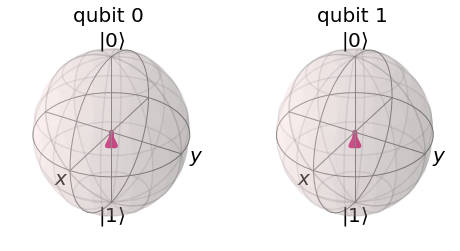

In [18]:
"""Visualize the mixed state on the Bloch sphere."""
backend = BasicAer.get_backend('statevector_simulator')
result = execute(bell, backend).result()
psi  = result.get_statevector(bell)

qiskit.visualization.plot_bloch_multivector(psi)

If we've traced over the Hilbert space of the $1^{st}$ qubit $\mathcal{H}_B$, the only thing we can say is that it has probability $p_0 = 1/2$ of being in the $|0\rangle$ state and $p_1 = 1/2$ of being in the $|1\rangle$ state. This isn't the same as $|\psi\rangle = 1/\sqrt{2} (|0\rangle + |1\rangle)$, which is a point on the surface of the bloch sphere: It's a point in the dead center of the bloch sphere! In fact, this state doesn't hold any information at all: all of the information is encoded in the correlation with the other qubit! 

We can recover this information by *measuring* the second qubit. The act of measuring the second qubit will not only project the second qubit into $|0\rangle$ or $|1\rangle$: since out two qubits are entangled, it will also collapse any superposition in the first qubit as well! Even though we prepared the first qubit in a __coherent__ superposition of $|0\rangle$ and $|1\rangle$, when we entangle with and measure the second qubit, we find it in and __incoherent__ superposition: Half the time it's in $|0\rangle$, half the time it's in $|1\rangle$, and the phase of those relative weights is *completely inaccessible by any experiment we might try*.

Run the code below. You'll see that the density matrix is sometimes $|00\rangle\langle00|$ and sometimes it's $|11\rangle\langle11|$, but try as you might, you'll never see the state vector of the $0^{th}$ qubit on the equator of the Bloch sphere, as if we had only applied a Hadamard to it.

In [19]:
"""Incoherent superpositions."""
# Prepare a bell state, and then measure qubit 2
incoh_sup = bell + meas2

backend = BasicAer.get_backend('statevector_simulator')
result = execute(incoh_sup, backend).result()
psi  = result.get_statevector(incoh_sup)

# Draw the circuit
incoh_sup.draw()

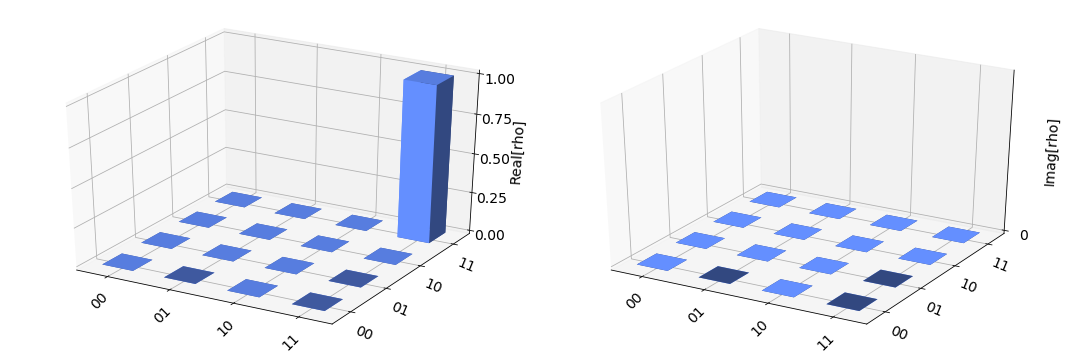

In [20]:
"""Visualize the incoherent superposition state."""
qiskit.visualization.plot_state_city(psi)

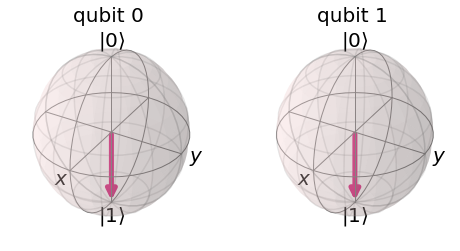

In [21]:
"""Visualize the reduced states."""
qiskit.visualization.plot_bloch_multivector(psi)

It's worth driving the point home that, after we prepared the first qubit with the Hadamard, we *never did anything* to it, and yet the act of measuring the second qubit changed the state vector of the first. When we entangle two qubits, *we can no longer think of them as separate systems!*

The idea that entangled qubits are more than the sum of their parts is fundamental to quantum computing and quantum information: the advantage quantum computers have over classical computers is imbedded in the fact that the Hilbert space grows exponentially in the number of qubits, and we'll see that the ability to distribute quantum information among multiple qubits leads to the idea of __quantum error correction__, which in theory allows us to do computations in the presence of (inevitable) noise.

# References and further reading

This notebook was meant to be instructive, but not too rigorous. If you're interested in a more formal introduction to the physics and mathematical concepts used in QC/QI, [chapters 2/3 John Preskill's notes](http://theory.caltech.edu/~preskill/ph229/) on quantum computing are a great place to start. Another great resource is chapter 2 of Michael Neilsen's and Issac Chuang's "Quantum Computing and Quantum Information."